In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import gymnasium as gym


# Réseau de neurones pour approximer Q(s, a)
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Agent DQN avec Experience Replay et ε-greedy
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hyperparamètres
        self.gamma = 0.99          # Facteur d'actualisation
        self.epsilon = 1.0         # Taux d'exploration initial
        self.epsilon_min = 0.01    # Exploration minimale
        self.epsilon_decay = 0.995 # Décroissance de ε
        self.learning_rate = 0.001
        self.batch_size = 64
        
        # Réseaux Q et Target
        self.q_network = DQNetwork(state_size, action_size)
        self.target_network = DQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # Experience Replay Buffer
        self.memory = deque(maxlen=10000)
    
    def remember(self, state, action, reward, next_state, done):
        """Stocker une transition dans la mémoire"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choisir une action avec ε-greedy"""
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()  # Exploitation
    
    def replay(self):
        """Entraîner le réseau sur un batch d'expériences"""
        if len(self.memory) < self.batch_size:
            return
        
        # Échantillonner un batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Q-values actuelles
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Q-values cibles (avec target network)
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q
        
        # Calcul de la perte et mise à jour
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Décroissance de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        """Copier les poids du Q-network vers le target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

print("✅ Agent DQN défini avec succès")

✅ Agent DQN défini avec succès


In [2]:
# load le modele entraîné
env = gym.make("LunarLander-v3")

# Initialiser l'agent
state_size = env.observation_space.shape[0]  # 8 observations
action_size = env.action_space.n             # 4 actions
agent = DQNAgent(state_size, action_size)

agent.q_network.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.q_network.eval()


DQNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# Tester l'agent avec rendu visuel
env = gym.make("LunarLander-v3", render_mode="human")

# Mode exploitation pure (epsilon = 0)
agent.epsilon = 0.0

n_test_episodes = 10
test_scores = []

for episode in range(n_test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    print(f"\n🎮 Test épisode {episode + 1}/{n_test_episodes}")
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        state = next_state
        total_reward += reward
    
    test_scores.append(total_reward)
    print(f"   Score : {total_reward:.2f}")

env.close()

print(f"\n✅ Score moyen sur {n_test_episodes} tests : {np.mean(test_scores):.2f}")
print(f"   (Objectif : 200+)")


🎮 Test épisode 1/10
   Score : 271.04

🎮 Test épisode 2/10
   Score : 248.76

🎮 Test épisode 3/10
   Score : 286.58

🎮 Test épisode 4/10
   Score : 271.92

🎮 Test épisode 5/10
   Score : -233.53

🎮 Test épisode 6/10
   Score : 286.45

🎮 Test épisode 7/10
   Score : 282.53

🎮 Test épisode 8/10
   Score : 287.88

🎮 Test épisode 9/10
   Score : 294.63

🎮 Test épisode 10/10
   Score : 249.65

✅ Score moyen sur 10 tests : 224.59
   (Objectif : 200+)


: 

# TRAINING

# Comment améliorer le Reinforcement Learning ?

## 🎯 Problème actuel
Le code ci-dessus utilise une **politique aléatoire** (`env.action_space.sample()`), ce qui ne permet pas d'apprentissage. L'agent choisit des actions au hasard sans tirer parti de l'expérience.

## 📚 Concepts clés pour l'amélioration

### 1. **Q-Learning (Tabular)**
- Apprendre une fonction de valeur Q(s, a) qui estime la récompense future attendue
- Mise à jour : `Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]`
- Paramètres : taux d'apprentissage α, facteur d'actualisation γ

### 2. **Exploration vs Exploitation (ε-greedy)**
- **Exploration** : essayer de nouvelles actions (probabilité ε)
- **Exploitation** : choisir la meilleure action connue (probabilité 1-ε)
- Décroissance de ε au fil du temps pour stabiliser la politique

### 3. **Deep Q-Network (DQN)**
- Pour espaces d'états continus/larges (comme LunarLander)
- Approximation de Q par un réseau de neurones
- Techniques : Experience Replay, Target Network, Double DQN

### 4. **Policy Gradient (REINFORCE, A2C, PPO)**
- Optimisation directe de la politique π(a|s)
- Avantages : fonctionne pour actions continues, convergence plus stable
- Actor-Critic : combine value function et policy gradient

### 5. **Techniques d'amélioration**
- **Reward Shaping** : modifier les récompenses pour guider l'apprentissage
- **Curriculum Learning** : commencer par des tâches simples
- **Hyperparameter Tuning** : learning rate, batch size, réseau architecture
- **Normalisation** : observations et récompenses

## 🚀 Implémentation : DQN pour LunarLander

Nous allons implémenter un agent **Deep Q-Network** qui apprend à atterrir correctement.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import gymnasium as gym


# Réseau de neurones pour approximer Q(s, a)
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Agent DQN avec Experience Replay et ε-greedy
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hyperparamètres
        self.gamma = 0.99          # Facteur d'actualisation
        self.epsilon = 1.0         # Taux d'exploration initial
        self.epsilon_min = 0.01    # Exploration minimale
        self.epsilon_decay = 0.995 # Décroissance de ε
        self.learning_rate = 0.001
        self.batch_size = 64
        
        # Réseaux Q et Target
        self.q_network = DQNetwork(state_size, action_size)
        self.target_network = DQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # Experience Replay Buffer
        self.memory = deque(maxlen=10000)
    
    def remember(self, state, action, reward, next_state, done):
        """Stocker une transition dans la mémoire"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choisir une action avec ε-greedy"""
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()  # Exploitation
    
    def replay(self):
        """Entraîner le réseau sur un batch d'expériences"""
        if len(self.memory) < self.batch_size:
            return
        
        # Échantillonner un batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Q-values actuelles
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Q-values cibles (avec target network)
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q
        
        # Calcul de la perte et mise à jour
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Décroissance de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        """Copier les poids du Q-network vers le target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

print("✅ Agent DQN défini avec succès")

✅ Agent DQN défini avec succès


### Entraînement de l'agent DQN

In [3]:
# Créer l'environnement (sans rendu pour l'entraînement)
env = gym.make("LunarLander-v3")

# Initialiser l'agent
state_size = env.observation_space.shape[0]  # 8 observations
action_size = env.action_space.n             # 4 actions
agent = DQNAgent(state_size, action_size)

# Paramètres d'entraînement
n_episodes = 10000
target_update_freq = 10  # Fréquence de mise à jour du target network

# Métriques
scores = []
epsilons = []
avg_scores = []

print(f"🎮 Début de l'entraînement sur {n_episodes} épisodes")
print(f"État : {state_size} dimensions, Actions : {action_size}\n")

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        # Choisir et exécuter une action
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Stocker la transition
        agent.remember(state, action, reward, next_state, done)
        
        # Entraîner l'agent
        agent.replay()
        
        state = next_state
        total_reward += reward
    
    # Mise à jour du target network
    if episode % target_update_freq == 0:
        agent.update_target_network()
    
    # Enregistrer les métriques
    scores.append(total_reward)
    epsilons.append(agent.epsilon)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    
    # Afficher les progrès
    if (episode + 1) % 50 == 0:
        print(f"Épisode {episode + 1}/{n_episodes} | "
              f"Score: {total_reward:.2f} | "
              f"Moyenne (100): {avg_score:.2f} | "
              f"ε: {agent.epsilon:.3f}")

env.close()
print("\n✅ Entraînement terminé!")

🎮 Début de l'entraînement sur 10000 épisodes
État : 8 dimensions, Actions : 4



/var/folders/zv/57zcksg520s80nvnwv8hr1kh0000gn/T/ipykernel_2231/2043635157.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  states = torch.FloatTensor(states)


Épisode 50/10000 | Score: -253.73 | Moyenne (100): -230.39 | ε: 0.010
Épisode 100/10000 | Score: -153.76 | Moyenne (100): -175.41 | ε: 0.010
Épisode 100/10000 | Score: -153.76 | Moyenne (100): -175.41 | ε: 0.010
Épisode 150/10000 | Score: -490.08 | Moyenne (100): -108.69 | ε: 0.010
Épisode 150/10000 | Score: -490.08 | Moyenne (100): -108.69 | ε: 0.010
Épisode 200/10000 | Score: -106.86 | Moyenne (100): -104.91 | ε: 0.010
Épisode 200/10000 | Score: -106.86 | Moyenne (100): -104.91 | ε: 0.010
Épisode 250/10000 | Score: -86.49 | Moyenne (100): -128.22 | ε: 0.010
Épisode 250/10000 | Score: -86.49 | Moyenne (100): -128.22 | ε: 0.010
Épisode 300/10000 | Score: -531.31 | Moyenne (100): -143.25 | ε: 0.010
Épisode 300/10000 | Score: -531.31 | Moyenne (100): -143.25 | ε: 0.010
Épisode 350/10000 | Score: -240.00 | Moyenne (100): -152.60 | ε: 0.010
Épisode 350/10000 | Score: -240.00 | Moyenne (100): -152.60 | ε: 0.010
Épisode 400/10000 | Score: -144.35 | Moyenne (100): -115.65 | ε: 0.010
Épisode 4

### 📊 Visualisation de l'apprentissage

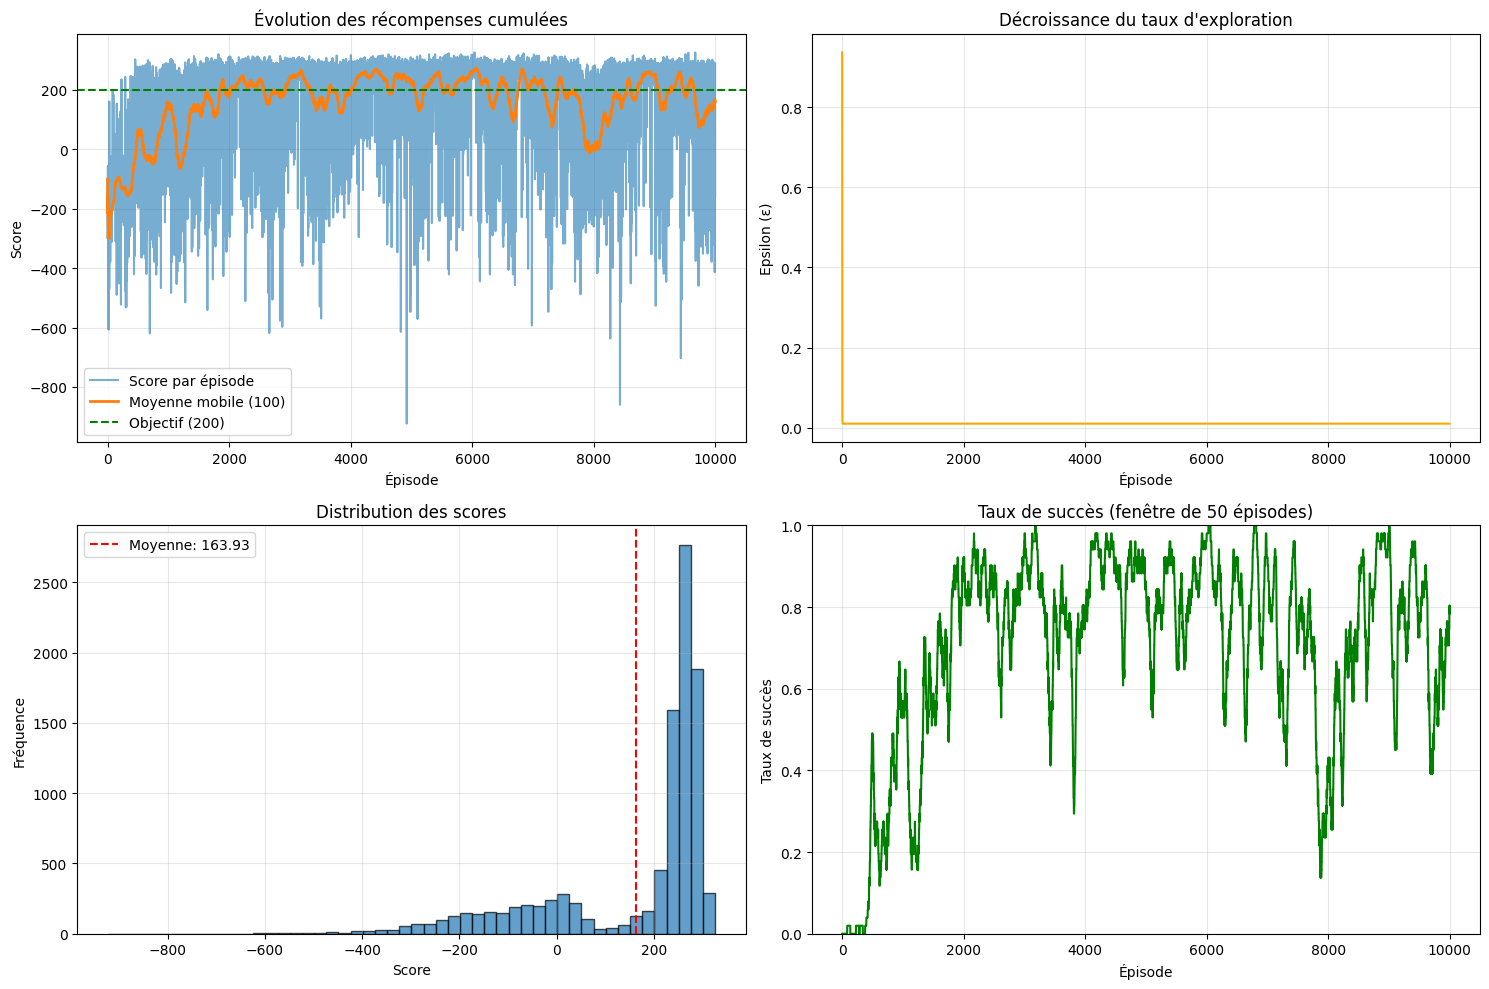


📈 Statistiques finales:
  • Score moyen : 163.93
  • Score médian : 250.85
  • Meilleur score : 326.36
  • Pire score : -923.46
  • Taux de succès global : 76.0%


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Récompenses par épisode
axes[0, 0].plot(scores, alpha=0.6, label='Score par épisode')
axes[0, 0].plot(avg_scores, linewidth=2, label='Moyenne mobile (100)')
axes[0, 0].axhline(y=200, color='g', linestyle='--', label='Objectif (200)')
axes[0, 0].set_xlabel('Épisode')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Évolution des récompenses cumulées')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Décroissance d'epsilon (exploration)
axes[0, 1].plot(epsilons, color='orange')
axes[0, 1].set_xlabel('Épisode')
axes[0, 1].set_ylabel('Epsilon (ε)')
axes[0, 1].set_title('Décroissance du taux d\'exploration')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution des scores
axes[1, 0].hist(scores, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=np.mean(scores), color='r', linestyle='--', 
                   label=f'Moyenne: {np.mean(scores):.2f}')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des scores')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Taux de succès (épisodes > 200)
window = 50
success_rate = [np.mean([1 if s > 200 else 0 for s in scores[max(0, i-window):i+1]]) 
                for i in range(len(scores))]
axes[1, 1].plot(success_rate, color='green')
axes[1, 1].set_xlabel('Épisode')
axes[1, 1].set_ylabel('Taux de succès')
axes[1, 1].set_title(f'Taux de succès (fenêtre de {window} épisodes)')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Statistiques finales:")
print(f"  • Score moyen : {np.mean(scores):.2f}")
print(f"  • Score médian : {np.median(scores):.2f}")
print(f"  • Meilleur score : {np.max(scores):.2f}")
print(f"  • Pire score : {np.min(scores):.2f}")
print(f"  • Taux de succès global : {np.mean([1 if s > 200 else 0 for s in scores[-100:]])*100:.1f}%")

### 🎬 Tester l'agent entraîné

In [2]:
# save le modele entraîné
torch.save(agent.q_network.state_dict(), "dqn_lunar_lander.pth")

NameError: name 'agent' is not defined

In [ ]:
# load le modele entraîné
env = gym.make("LunarLander-v3")

# Initialiser l'agent
state_size = env.observation_space.shape[0]  # 8 observations
action_size = env.action_space.n             # 4 actions
agent = DQNAgent(state_size, action_size)

agent.q_network.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.q_network.eval()


DQNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [7]:
# Tester l'agent avec rendu visuel
env = gym.make("LunarLander-v3", render_mode="human")

# Mode exploitation pure (epsilon = 0)
agent.epsilon = 0.0

n_test_episodes = 10
test_scores = []

for episode in range(n_test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    print(f"\n🎮 Test épisode {episode + 1}/{n_test_episodes}")
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        state = next_state
        total_reward += reward
    
    test_scores.append(total_reward)
    print(f"   Score : {total_reward:.2f}")

env.close()

print(f"\n✅ Score moyen sur {n_test_episodes} tests : {np.mean(test_scores):.2f}")
print(f"   (Objectif : 200+)")


🎮 Test épisode 1/10
   Score : 277.38

🎮 Test épisode 2/10


KeyboardInterrupt: 

---

## 🎓 Résumé des améliorations appliquées

### ✅ Ce que nous avons implémenté :

1. **Deep Q-Network (DQN)**
   - Réseau de neurones pour approximer Q(s, a)
   - Architecture : 8 → 128 → 128 → 4

2. **Experience Replay**
   - Buffer de 10 000 transitions
   - Batch learning de 64 expériences
   - Décorrélation des échantillons d'apprentissage

3. **Target Network**
   - Réseau cible mis à jour tous les 10 épisodes
   - Stabilise l'entraînement en fixant temporairement les cibles

4. **Stratégie ε-greedy**
   - Exploration initiale : ε = 1.0
   - Décroissance : × 0.995 par épisode
   - Minimum : ε = 0.01

5. **Visualisation**
   - Courbes d'apprentissage
   - Taux de succès
   - Distribution des scores

### 🚀 Améliorations supplémentaires possibles :

#### **Double DQN**
```python
# Au lieu de : max Q(s', a')
# Utiliser : Q_target(s', argmax Q_online(s', a'))
```
Réduit le biais d'overestimation des Q-values.

#### **Prioritized Experience Replay**
Échantillonner plus souvent les transitions importantes (erreur TD élevée).

#### **Dueling DQN**
Séparer l'estimation de V(s) et A(s, a) pour une meilleure généralisation.

#### **Algorithmes plus avancés**
- **PPO (Proximal Policy Optimization)** : plus stable et sample-efficient
- **A3C/A2C** : Actor-Critic asynchrone
- **SAC (Soft Actor-Critic)** : pour actions continues
- **Rainbow DQN** : combine 6+ améliorations

#### **Optimisation des hyperparamètres**
- Learning rate scheduling
- Adaptive epsilon decay
- Batch size, buffer size, architecture du réseau

#### **Reward Shaping**
Ajouter des récompenses intermédiaires pour guider l'apprentissage plus rapidement.

---

## 📖 Concepts de cours utilisés

| Concept | Application | Cours associé |
|---------|-------------|---------------|
| **Équation de Bellman** | Q(s,a) = r + γ max Q(s',a') | RL-01, RL-02 |
| **Exploration vs Exploitation** | ε-greedy | RL-01, RL-03 |
| **TD Learning** | Mise à jour temporelle | RL-02 |
| **Function Approximation** | Réseau de neurones | RL-04, RL-05 |
| **Off-Policy Learning** | Experience Replay | RL-03, RL-04 |
| **Stabilité d'entraînement** | Target Network | RL-05 |